# Adversarial examples (0.2 балла)

В этом разделе мы будем создавать adversarial примеры для типичной архитектуры сетей. Для начала нужно сделать простую сверточную сеть для классификации (2-3 слоя) и обучить ее до нормального качества (>98%). Для экономии времени не нужно обучать ее слишком много эпох как мы это делали ранее.

*Упражнение.* Можете попробовать дома обучить сеть до сходимости и сравнить, какой из вариантов более уязвим к таким атакам.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data.sampler import Sampler, BatchSampler
from torch.nn.modules.loss import MSELoss

In [2]:
input_size = 784
num_classes = 10
batch_size = 256

train_dataset = dsets.MNIST(root='./MNIST/', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.MNIST(root='./MNIST/', 
                           train=False, 
                           transform=transforms.ToTensor())


train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size,         
                                          shuffle=False)

In [412]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size()[0], -1)

class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.Dropout(),
            nn.MaxPool2d(2),
            nn.ReLU(),
            Flatten(),
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Linear(50, 10),
            nn.LogSoftmax(-1)
            )
    
    def forward(self, x):
        output = self.cnn(x)
        return output

In [413]:
from tqdm import trange

        
def train_epoch(model, optimizer, batchsize=32):
    loss_log, acc_log = [], []
    model.train()
    for _, (x_batch, y_batch) in zip(trange(len(train_loader)), train_loader):
        data = Variable(x_batch)
        target = Variable(y_batch)
        optimizer.zero_grad()
        output = model(data)   
        
        pred = torch.max(output, 1)[1].data.numpy()
        acc = np.mean(pred == y_batch)
        acc_log.append(acc)
        
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        loss = loss.data[0]
        loss_log.append(loss)
    return loss_log, acc_log

def test(model):
    loss_log, acc_log = [], []
    model.eval()
    for batch_num, (x_batch, y_batch) in enumerate(test_loader):  
        data = Variable(x_batch)
        target = Variable(y_batch)
        output = model(data)
        loss = F.nll_loss(output, target)
        
        pred = torch.max(output, 1)[1].data.numpy()
        acc = np.mean(pred == y_batch)
        acc_log.append(acc)
        
        loss = loss.data[0]
        loss_log.append(loss)
    return loss_log, acc_log

def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    
    points = np.array(val_history)
    
    plt.scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()
    
def train(model, opt, n_epochs):
    train_log, train_acc_log = [], []
    val_log, val_acc_log = [], []

    batchsize = 32

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, opt, batchsize=batchsize)

        val_loss, val_acc = test(model)

        train_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        steps = train_dataset.train_labels.shape[0] / batch_size
        val_log.append((steps * (epoch + 1), np.mean(val_loss)))
        val_acc_log.append((steps * (epoch + 1), np.mean(val_acc)))

        clear_output()
        plot_history(train_log, val_log)    
        plot_history(train_acc_log, val_acc_log, title='accuracy')   
            
    print("Final error: {:.2%}".format(1 - val_acc_log[-1][1]))

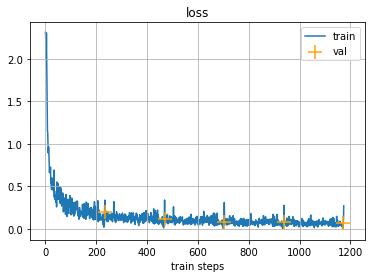

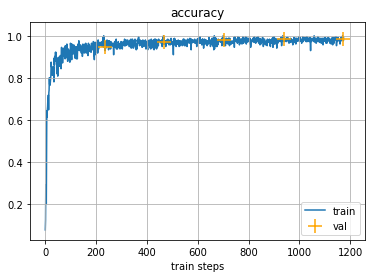

Final error: 1.43%
Wall time: 1min 34s


In [414]:
%%time

model = ConvNet()
opt = torch.optim.RMSprop(model.parameters(), lr=0.001)
train(model, opt, 5)

Теперь возьмем несколько изображений, которые мы будем пытаться искажать.

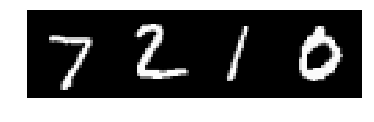

[7 2 1 0]


In [415]:
import torchvision

inputs, labels = iter(test_loader).next()
inputs = inputs[:4]
labels = labels[:4]

def imshow(images):
    img = images
    img = torchvision.utils.make_grid(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()
imshow(inputs)
print(labels.numpy())

Реализуйте простой способ adversarial-атаки: сделайте шаг градиентного подъема по входам (изображениям) для увеличения ошибки классификации. Подберите шаг, чтобы значения предсказания уже начинали меняться, но визуально цифра мало менялась (т.е. вы бы по-прежнему ее распознали как ту же цифру с высокой уверенностью).

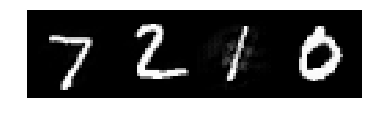

In [425]:
def corrupt_simple(inputs, labels, model, weight):
    model.zero_grad()
    x = Variable(inputs, requires_grad=True)
    y = Variable(labels)
    out = model(x)
    loss = F.nll_loss(out, y)
    loss.backward()
    corrupted_inputs = x + weight * x.grad
    corrupted_inputs = torch.clamp(corrupted_inputs, 0.0, 1.0)    
    return corrupted_inputs

corrupted_inputs = corrupt_simple(inputs, labels, model, 50)
imshow(corrupted_inputs.data)

In [426]:
outputs = model(corrupted_inputs)
_, predicted = torch.max(outputs.data, 1)
print(predicted.numpy())

[7 2 4 0]


Видно, что в таком подходе приходится уже сильно исказить изображение, чтобы ответы начали меняться. Если вместо градиента использовать только его знак (по каждой координате), то результаты получаются лучше. Реализуйте такой метод.

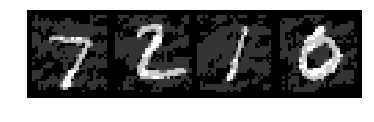

In [437]:
def corrupt_sign(inputs, labels, model, weight):
    model.zero_grad()
    x = Variable(inputs, requires_grad=True)
    y = Variable(labels)
    out = model(x)
    loss = F.nll_loss(out, y)
    loss.backward()
    corrupted_inputs = x + weight * torch.sign(x.grad)
    corrupted_inputs = torch.clamp(corrupted_inputs, 0.0, 1.0)    
    return corrupted_inputs

corrupted_inputs = corrupt_sign(inputs, labels, model, 0.2)
imshow(corrupted_inputs.data)

In [438]:
outputs = model(corrupted_inputs)
_, predicted = torch.max(outputs.data, 1)
print(predicted.numpy())

[3 8 8 0]


Теперь посмотрим как сильно меняется точность на всей выборке.

In [439]:
def evaluate_network_attack(net, corrupt_function, weight):
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    for data in test_loader:
        images, labels = data
        images = corrupt_function(images, labels, net, weight)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i]
            class_total[label] += 1

    print('Accuracy %d %% \n' % (100 * sum(class_correct) / sum(class_total)))
        
    for i in range(10):
        print('Accuracy of %2s : %2d %%' % (
              i, 100 * class_correct[i] / class_total[i]))

In [440]:
evaluate_network_attack(model, corrupt_simple, 1000)

Accuracy 88 % 

Accuracy of  0 : 100 %
Accuracy of  1 : 88 %
Accuracy of  2 : 88 %
Accuracy of  3 : 87 %
Accuracy of  4 : 95 %
Accuracy of  5 : 80 %
Accuracy of  6 : 92 %
Accuracy of  7 : 53 %
Accuracy of  8 : 100 %
Accuracy of  9 : 95 %


In [441]:
evaluate_network_attack(model, corrupt_sign, 0.2)

Accuracy 27 % 

Accuracy of  0 : 69 %
Accuracy of  1 : 17 %
Accuracy of  2 : 27 %
Accuracy of  3 : 43 %
Accuracy of  4 : 13 %
Accuracy of  5 : 30 %
Accuracy of  6 : 14 %
Accuracy of  7 :  6 %
Accuracy of  8 : 57 %
Accuracy of  9 : 14 %


### Обучение до сходимости

*Теперь будем атаковать сеть, обученную до сходимости. Для ее обучения немного видоизменим соответствующую ранее введенную функцию, чтобы она работала для данного случая.*  

In [442]:
def train_till_conv(model, opt, eps):
    train_log, train_acc_log = [], []
    val_log, val_acc_log = [], []

    batchsize = 32
    epoch = 0
    while True:
        train_loss, train_acc = train_epoch(model, opt, batchsize=batchsize)
        val_loss, val_acc = test(model)

        train_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        steps = train_dataset.train_labels.shape[0] / batch_size
        val_log.append((steps * (epoch + 1), np.mean(val_loss)))
        val_acc_log.append((steps * (epoch + 1), np.mean(val_acc)))

        clear_output()
        plot_history(train_log, val_log)    
        plot_history(train_acc_log, val_acc_log, title='accuracy')
        if sum(train_loss[-batchsize:]) / batchsize < eps:
            break
        else:
            epoch += 1
            
    print("Final error: {:.2%}".format(1 - val_acc_log[-1][1]))
    print("Number of epochs: {}".format(epoch + 1))

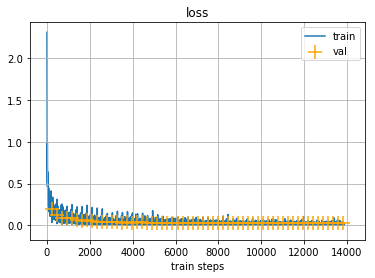

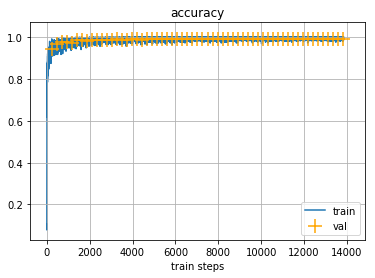

Final error: 0.96%
Number of epochs: 59
Wall time: 18min 34s


In [443]:
%%time

model = ConvNet()
opt = torch.optim.RMSprop(model.parameters(), lr=0.001)
train_till_conv(model, opt, 0.01)

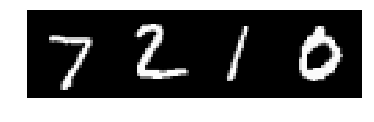

[7 2 1 0]


In [444]:
imshow(inputs)
print(labels.numpy())

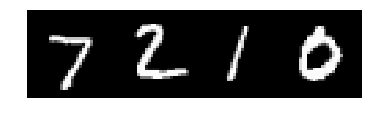

In [445]:
corrupted_inputs = corrupt_simple(inputs, labels, model, 50)
imshow(corrupted_inputs.data)

In [446]:
outputs = model(corrupted_inputs)
_, predicted = torch.max(outputs.data, 1)
print(predicted.numpy())

[7 2 1 0]


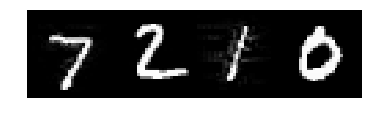

In [449]:
corrupted_inputs = corrupt_simple(inputs, labels, model, 5000)
imshow(corrupted_inputs.data)

In [450]:
outputs = model(corrupted_inputs)
_, predicted = torch.max(outputs.data, 1)
print(predicted.numpy())

[7 2 5 0]


*Видно, что данная модель более устойчива к простому градиентному подъему, чем предыдущая, и, чтобы получить незначительные изменения в качестве предсказания, приходится увеличить соответствующий вес на два порядка.*

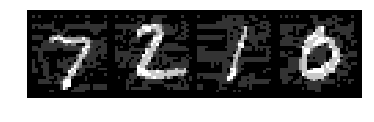

In [451]:
corrupted_inputs = corrupt_sign(inputs, labels, model, 0.2)
imshow(corrupted_inputs.data)

In [452]:
outputs = model(corrupted_inputs)
_, predicted = torch.max(outputs.data, 1)
print(predicted.numpy())

[7 2 3 0]


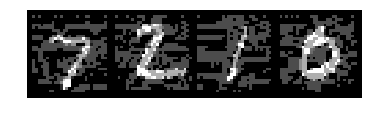

In [455]:
corrupted_inputs = corrupt_sign(inputs, labels, model, 0.3)
imshow(corrupted_inputs.data)

In [456]:
outputs = model(corrupted_inputs)
_, predicted = torch.max(outputs.data, 1)
print(predicted.numpy())

[7 8 3 2]


*Как и в случае простого градиентного подъема, в данном случае рассматриваемая модель также оказывается устойчивее, чем предыдущая.*

In [457]:
evaluate_network_attack(model, corrupt_simple, 1000)

Accuracy 96 % 

Accuracy of  0 : 100 %
Accuracy of  1 : 94 %
Accuracy of  2 : 94 %
Accuracy of  3 : 100 %
Accuracy of  4 : 100 %
Accuracy of  5 : 90 %
Accuracy of  6 : 92 %
Accuracy of  7 : 93 %
Accuracy of  8 : 100 %
Accuracy of  9 : 95 %


In [458]:
evaluate_network_attack(model, corrupt_sign, 0.2)

Accuracy 35 % 

Accuracy of  0 : 61 %
Accuracy of  1 : 17 %
Accuracy of  2 : 44 %
Accuracy of  3 : 50 %
Accuracy of  4 : 40 %
Accuracy of  5 : 70 %
Accuracy of  6 :  7 %
Accuracy of  7 : 20 %
Accuracy of  8 : 50 %
Accuracy of  9 :  9 %


*Итак, обучение до сходимости позволяет сети быть устойчивее к атакам и обеспечивает лучшую точность на выборке в случае атаки.*

# Adversarial networks (0.8 балла)

На этом семинаре мы поработаем с adversarial-архитектурами. Мы не будем обучать полноценную генеративную модель (GAN), так как это потребует много времени, а вместо этого вернемся к задаче повышения разрешения изображений и попробуем улучшить нашу модель с помощью advesarial-подхода (получится упрощенный SRGAN).

Как мы обсуждали ранее, MSE хоть и является простой и удобной метрикой, она плохо отражает визуальные характеристики изображений. Поэтому мы добавим дискриминатор, который будет пытаться отличить изображения высокого качества от наших результатов, и в модели повышающей разрешение будем пытаться его обмануть.

Если это записать строго, то у нас будут две сети: $D$ - дискриминатор и $E$ - сеть, повышающая разрешение, и оптимизировать мы для них будем следующие целевые функции соответсвенно:

$$
    \min_D \bigl[ \mathrm{BCE}(D(E(x_l)), 0) + \mathrm{BCE}(D(x_h), 1) \bigr],
$$

$$
    \min_E \bigl[ \| E(x_l) - x_h \|_2^2 - \lambda \cdot \mathrm{BCE}(D(E(x_l)), 0) \bigr],
$$

где $BCE(l, y)$ - бинарная кросс-энтропия между ответами $l$ и метками $y$, $x_l$ - изображения низкого качества, $x_h$ - изображения высокого качества.

*Упражнение.* Почему в целевой функции для $D$ нет компоненты $\mathrm{BCE}(D(x_h), 1)$?

*Вероятно, в формулировке упражнения опечатка, и имеется в виду целевая функция для $E$. По сути рассматриваемая компонента определяет степень близости $D(x_h)$ и метками $1$. Чем она меньше, тем лучше для дискриминатора, ибо его задача — положительно реагировать на исходные изображения высокого качества ($x_h$). Однако она никак не задействует сеть, повышающую разрешение, и, исходя из сути происходящего, ее добавление имеет смысл лишь для целевой функции для дискриминатора.*

Для начала продублируем код с позапрошлого семинара, чтобы у нас была сеть для сравнения. Используйте архитектуру с двумя сверточными слоями для простоты.

In [459]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size,         
                                          shuffle=False)

In [460]:
n_kernels = 5

class SuperResolutionNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, n_kernels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(n_kernels, 1, kernel_size=3, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        output = self.cnn1(x)
        return output + x

In [461]:
srcnn = SuperResolutionNetwork()

In [462]:
from tqdm import trange

def low_res_and_high_res(images_batch):
    result = images_batch.clone()
    low_res_transform = transforms.Resize((14,14))
    high_res_transform = transforms.Resize((28,28))
    toTensorTransform = transforms.ToTensor()
    toImageTransform = transforms.ToPILImage()
    for i in range(images_batch.size()[0]):
        result[i] = toTensorTransform(high_res_transform(low_res_transform(toImageTransform(images_batch[i]))))
    return result

def train_epoch(model, optimizer, batchsize=32):
    loss_log = []
    model.train()
    for _, (x_batch_base, _) in zip(trange(len(train_loader)), train_loader):
        x_batch = x_batch_base.float()
        data = Variable(low_res_and_high_res(x_batch))
        target = Variable(x_batch)
        optimizer.zero_grad()
        output = model(data)        
        loss = F.mse_loss(output, target)
        loss.backward()
        optimizer.step()
        loss = loss.data.cpu()[0]
        loss_log.append(loss)
    return loss_log   

def test(model):
    loss_log = []
    model.eval()
    for batch_num, (x_batch, y_batch) in enumerate(test_loader):    
        x_batch = x_batch.float()
        data = Variable(low_res_and_high_res(x_batch))
        target = Variable(x_batch)
        output = model(data)
        loss = F.mse_loss(output, target)        
        loss = loss.data.cpu()[0]
        loss_log.append(loss)
    return loss_log

def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    points = np.array(val_history)
    plt.scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    
def train(model, opt, n_epochs):
    train_log = []
    val_log = []
    for epoch in range(n_epochs):
        train_loss = train_epoch(model, opt, batchsize=batch_size)
        val_loss = test(model)
        train_log.extend(train_loss)
        steps = train_dataset.train_labels.shape[0] / batch_size
        val_log.append((steps * (epoch + 1), np.mean(val_loss)))
        clear_output()
        plot_history(train_log, val_log)    

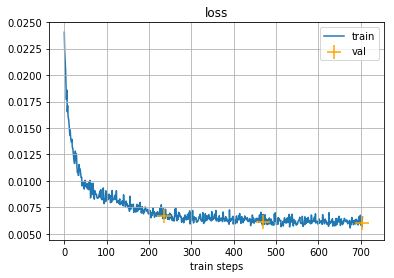

Wall time: 1min 7s


In [463]:
%%time 

opt = torch.optim.Adam(srcnn.parameters(), lr=0.005)
train(srcnn, opt, 3)

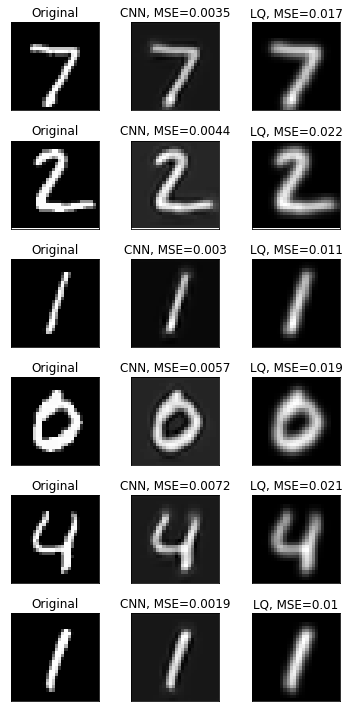

In [464]:
test_images = test_dataset.test_data.float() / 255
test_images_blurred = low_res_and_high_res(test_images[:100].view(-1,1,28,28))
result_cnn = srcnn(Variable(test_images_blurred))

examplesCount = 6
plt.figure(figsize=[5, 10])
for i in range(examplesCount):
    plt.subplot(examplesCount, 3, i * 3 + 1)
    plt.title("Original")
    plt.imshow(test_images[i].numpy().reshape([28, 28]), cmap='gray')
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(examplesCount, 3, i * 3 + 2)
    mse = np.mean((test_images[i].numpy() - result_cnn[i].data.numpy())**2)
    plt.title("CNN, MSE={:.2}".format(mse))
    plt.imshow(result_cnn[i].data.numpy().reshape([28, 28]), cmap='gray')
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(examplesCount, 3, i * 3 + 3)
    mse = np.mean((test_images[i].numpy() - test_images_blurred[i].numpy())**2)
    plt.title("LQ, MSE={:.2}".format(mse))
    plt.imshow(test_images_blurred[i].numpy().reshape([28, 28]), cmap='gray')
    plt.xticks([])
    plt.yticks([])
    
plt.tight_layout()

Теперь переходим к adversarial модели. Создайте простую сеть (2-3 слоя) для бинарной классификации изображений.

In [470]:
class DiscriminatorNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.Dropout(),
            nn.MaxPool2d(2),
            nn.ReLU(),
            Flatten(),
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Linear(50, 2),
            nn.LogSoftmax(-1)
            )
    
    def forward(self, x):
        output = self.cnn(x)
        return output

In [471]:
srgan = SuperResolutionNetwork()
disc = DiscriminatorNetwork()

При оптимизации adversarial-архитектур возникает дополнительная сложность - сети необходимо оптимизировать поочередно. Иногда для них приходится подбирать оптимальное соотношение числа шагов, но мы ограничимся вариантом 1:1. Допишите недостающий код оптимизации ниже.

In [472]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size,         
                                          shuffle=False)

In [473]:
from tqdm import trange

def low_res_and_high_res(images_batch):
    result = images_batch.clone()
    low_res_transform = transforms.Resize((14,14))
    high_res_transform = transforms.Resize((28,28))
    toTensorTransform = transforms.ToTensor()
    toImageTransform = transforms.ToPILImage()
    for i in range(images_batch.size()[0]):
        result[i] = toTensorTransform(high_res_transform(low_res_transform(toImageTransform(images_batch[i]))))
    return result


DISC_LOSS_WEIGHT = 0.1

def losses(model, disc, x_batch):
    data = Variable(low_res_and_high_res(x_batch))
    target = Variable(x_batch)
    output = model(data)

    disc_output = disc(output)
    disc_target = disc(target)
    label_zeros, label_ones = Variable(torch.zeros(data.shape[0])), Variable(torch.ones(data.shape[0]))
    model_diff_norm = torch.norm((output - target).view(data.shape[0], -1), p=2, dim=1)
    bce_disc_model_data = -(label_zeros * disc_output.max(1)[0] + (1 - label_zeros) * disc_output.min(1)[0])
    bce_disc_target = -(label_ones * disc_target.max(1)[0] + (1 - label_ones) * disc_target.min(1)[0])
    
    disc_loss = torch.mean(bce_disc_model_data + bce_disc_target)
    model_loss = torch.mean(model_diff_norm - DISC_LOSS_WEIGHT * bce_disc_model_data)
    
    return disc_loss, model_loss
    

def train_epoch(model, disc, m_opt, d_opt, batchsize=32):
    d_loss_log = []
    m_loss_log = []
    model.train()
    for batch_num, (x_batch_base, _) in zip(trange(len(train_loader)), train_loader):
        x_batch = x_batch_base.float()
        d_loss, m_loss = losses(model, disc, x_batch)
            
        d_opt.zero_grad()
        d_loss.backward(retain_graph=True)
        d_opt.step()
        
        m_opt.zero_grad()
        m_loss.backward()
        m_opt.step()
            
        d_loss_log.append(d_loss.data[0])
        m_loss_log.append(m_loss.data[0])
    return d_loss_log, m_loss_log 

def test(model, disc):
    d_loss_log = []
    m_loss_log = []
    model.eval()
    for batch_num, (x_batch, y_batch) in enumerate(test_loader):
        d_loss, m_loss = losses(model, disc, x_batch)
        d_loss_log.append(d_loss.data[0])
        m_loss_log.append(m_loss.data[0])
    return d_loss_log, m_loss_log 

def plot_history(train_history, val_history, title='loss'):
    plt.figure(figsize=(8, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_history[0], label='train', zorder=1)
    points = np.array(val_history)
    plt.scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
    plt.title('Discriminator loss')
    plt.xlabel('train steps')
    plt.legend(loc='best')
    plt.grid()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_history[1], label='train', zorder=1)
    points = np.array(val_history)
    plt.scatter(points[:, 0], points[:, 2], marker='+', s=180, c='orange', label='val', zorder=2)
    plt.title('Model loss')
    plt.xlabel('train steps')
    plt.legend(loc='best')
    plt.grid()
    
    plt.show()
    
def train(model, disc, m_opt, d_opt, n_epochs):
    train_log = [[], []]
    val_log = []
    for epoch in range(n_epochs):
        train_loss = train_epoch(model, disc, m_opt, d_opt, batchsize=batch_size)
        val_loss = test(model, disc)
        train_log[0].extend(train_loss[0])
        train_log[1].extend(train_loss[1])
        steps = train_dataset.train_labels.shape[0] / batch_size
        val_log.append((steps * (epoch + 1), np.mean(val_loss[0]), np.mean(val_loss[1])))
        clear_output()
        plot_history(train_log, val_log)    

Теперь запустим оптимизацию. Большая проблема при работе с adversarial-моделями - в том, что по графикам оптимизации мало чего понятно. То есть по ним можно увидеть какое-то совсем плохое поведение и, возможно, найти ошибки в коде, но вот понять, дообучилась ли сеть, или ее еще стоит пообучать, часто нельзя. Обычно все метрики просто колеблются вокруг константы, но при этом сеть обучается (по очереди происходит небольшое улучшение дискриминатора, а потом оно тут же убирается основной сетью).

Обучите сеть на 2-3 эпохах и добейтесь, чтобы влияние adversarial-потерь было заметно (на примерах ниже). Для этого потребуется, чтобы качество дискриминатора не ушло совсем в 0. Возможно, придется немного поиграться с параметрами.

Потом дома можно оставить обучение на 5-10 эпох и увидеть изменения в качестве.

Также обратите внимание, что MSE для adversarial-архитектуры выходит хуже, чем обычной. Но мы так и планировали сделать - ведь MSE плохо оценивает визуальное качество.

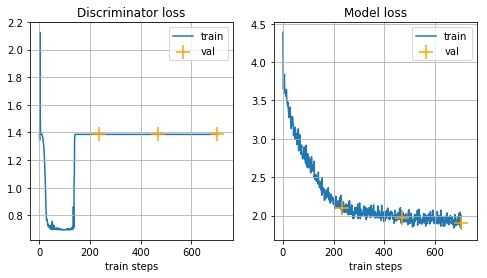

Wall time: 3min 22s


In [474]:
%%time

m_opt = torch.optim.Adam(srgan.parameters(), lr=0.005)
d_opt = torch.optim.Adam(disc.parameters(), lr=0.005)
train(srgan, disc, m_opt, d_opt, 3)

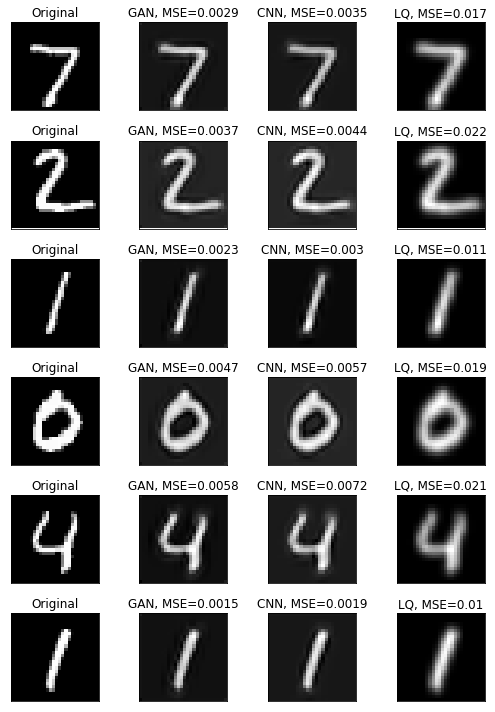

In [476]:
test_images = test_dataset.test_data.float() / 255
test_images_blurred = low_res_and_high_res(test_images[:100].view(-1,1,28,28))
result_cnn = srcnn(Variable(test_images_blurred))
result_gan = srgan(Variable(test_images_blurred))

examplesCount = 6
rows, cols = examplesCount, 4
plt.figure(figsize=[7, 10])
for i in range(examplesCount):
    plt.subplot(rows, cols, i * cols + 1)
    plt.title("Original")
    plt.imshow(test_images[i].numpy().reshape([28, 28]), cmap='gray')
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(rows, cols, i * cols + 2)
    mse = np.mean((test_images[i].numpy() - result_gan[i].data.numpy())**2)
    plt.title("GAN, MSE={:.2}".format(mse))
    #plt.title(mse)
    plt.imshow(result_gan[i].data.numpy().reshape([28, 28]), cmap='gray')
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(rows, cols, i * cols + 3)
    mse = np.mean((test_images[i].numpy() - result_cnn[i].data.numpy())**2)
    plt.title("CNN, MSE={:.2}".format(mse))
    #plt.title(mse)
    plt.imshow(result_cnn[i].data.numpy().reshape([28, 28]), cmap='gray')
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(rows, cols, i * cols + 4)
    mse = np.mean((test_images[i].numpy() - test_images_blurred[i].numpy())**2)
    plt.title("LQ, MSE={:.2}".format(mse))
    #plt.title(mse)
    plt.imshow(test_images_blurred[i].numpy().reshape([28, 28]), cmap='gray')
    plt.xticks([])
    plt.yticks([])
    
plt.tight_layout()

*Действительно, если увеличить число эпох, можно заметить небольшой прирост в качестве.*

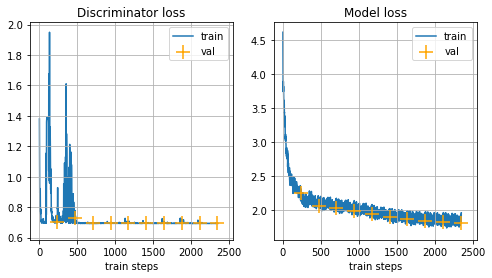

Wall time: 10min 48s


In [478]:
%%time

srgan = SuperResolutionNetwork()
disc = DiscriminatorNetwork()
m_opt = torch.optim.Adam(srgan.parameters(), lr=0.005)
d_opt = torch.optim.Adam(disc.parameters(), lr=0.005)
train(srgan, disc, m_opt, d_opt, 10)

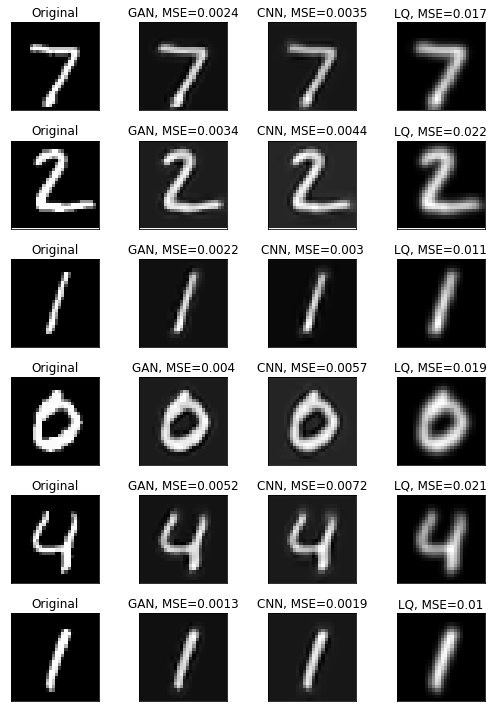

In [479]:
test_images = test_dataset.test_data.float() / 255
test_images_blurred = low_res_and_high_res(test_images[:100].view(-1,1,28,28))
result_cnn = srcnn(Variable(test_images_blurred))
result_gan = srgan(Variable(test_images_blurred))

examplesCount = 6
rows, cols = examplesCount, 4
plt.figure(figsize=[7, 10])
for i in range(examplesCount):
    plt.subplot(rows, cols, i * cols + 1)
    plt.title("Original")
    plt.imshow(test_images[i].numpy().reshape([28, 28]), cmap='gray')
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(rows, cols, i * cols + 2)
    mse = np.mean((test_images[i].numpy() - result_gan[i].data.numpy())**2)
    plt.title("GAN, MSE={:.2}".format(mse))
    #plt.title(mse)
    plt.imshow(result_gan[i].data.numpy().reshape([28, 28]), cmap='gray')
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(rows, cols, i * cols + 3)
    mse = np.mean((test_images[i].numpy() - result_cnn[i].data.numpy())**2)
    plt.title("CNN, MSE={:.2}".format(mse))
    #plt.title(mse)
    plt.imshow(result_cnn[i].data.numpy().reshape([28, 28]), cmap='gray')
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(rows, cols, i * cols + 4)
    mse = np.mean((test_images[i].numpy() - test_images_blurred[i].numpy())**2)
    plt.title("LQ, MSE={:.2}".format(mse))
    #plt.title(mse)
    plt.imshow(test_images_blurred[i].numpy().reshape([28, 28]), cmap='gray')
    plt.xticks([])
    plt.yticks([])
    
plt.tight_layout()